# Usage of eABF and WTMeABF

We will again analyze the improper dihedral of ammiona as in 16


To analyse the umbrella sampling results, please install 
https://github.com/ochsenfeld-lab/adaptive_sampling

### Imports

In [1]:
path_to_adaptivesampling = "/home/jdiet/AdvSampl"

In [2]:
import os
import sys
sys.path.append(path_to_adaptivesampling)

In [3]:
import numpy as np
import matplotlib.pyplot as plt

from ase import Atoms

from nff.train import load_model
from ase import units
from nff.io.ase import AtomsBatch
from nff.io.ase_calcs import NeuralFF

In [4]:
from ase.io import Trajectory as trajectory
from ase.io import write, read
import nglview as nv
from tqdm import tqdm

In [5]:
from nff.md.nvt import Langevin
from nff.md.colvars import ColVar
from nff.io.bias_calculators import BiasBase, eABF, WTMeABF
from nff.md.utils import BiasedNeuralMDLogger

In [6]:
from adaptive_sampling.processing_tools import mbar
from adaptive_sampling.processing_tools.utils import *
from adaptive_sampling import units

In [7]:
plt.rc("text", usetex=True)
plt.rc("font", family="serif")

### Loading the starting structure 

In [20]:
start_geom = read("models/ammonia/Ammonia.xyz")

In [21]:
# central dictionray for the ColVar class
# in this tutorial we will use the improper dihedral of ammonia
info_dict = {'name': 'dihedral',
             'index_list': [0, 1, 2, 3], }

atoms = AtomsBatch.from_atoms(start_geom,
                              )

# use the distance of the scan for center of umbrella window
CV = ColVar(info_dict)
cv, cv_grad = CV(atoms)

print(f"Start value: {cv*180/np.pi} degrees = {cv} radians")

Start value: 36.932241080713766 degrees = 0.6445892069987641 radians


### Setting up eABF

In [22]:
device = 'cpu'

cv_defs = [{'definition': info_dict,
            'range': [-1.0, 1.0],
            'ext_sigma': 0.05,  # approx k = 10 eV/(cv-unit)^2
            'ext_mass': 20.0,
            'ext_pos': cv,  # the starting position of the extended coordinate
            'margin': 0.1,
            'conf_k': 0.1,
            'type': 'angle',
            }
           ]

model = load_model('models/ammonia/',
                   device=device)

calculator = eABF(model,
                  cv_defs=cv_defs,
                  dt=0.5,
                  friction_per_ps=1.0,
                  equil_temp=300.0,
                  nfull=100,
                  directed=True,
                  device=device,
                  )

atoms.set_calculator(calculator)

dyn = Langevin(atoms,
               timestep=0.5,
               temperature=300.0,
               friction_per_ps=1.0,
               maxwell_temp=300.0,
               logfile='eABF_MD.log',
               trajectory='eABF.traj',
               )

dyn.attach(BiasedNeuralMDLogger(dyn,
                                atoms,
                                'eABF_ext.log',
                                header=True,
                                mode="w"),
           interval=2)

THE RANDOM NUMBER SEED WAS: 621708439


In [23]:
# trajectory of 25 ps (umbrella sampling was 41 ps)
dyn.run(steps=int(5e4))

100%|██████████| 2500/2500 [06:04<00:00,  6.86it/s]


In [24]:
traj = trajectory("eABF.traj", mode="r")
nv.show_asetraj(traj)

NGLWidget(max_frame=50000)

In [25]:
exttraj = np.genfromtxt("eABF_ext.log", skip_header=1)

In [26]:
!head -n 1 eABF_ext.log

Time[ps]     Epot_biased[eV]   Epot_nobias[eV]   AbsGradPot          CV       Lambda     inv_m_cv    AbsGradCV   GradCV_GradPot


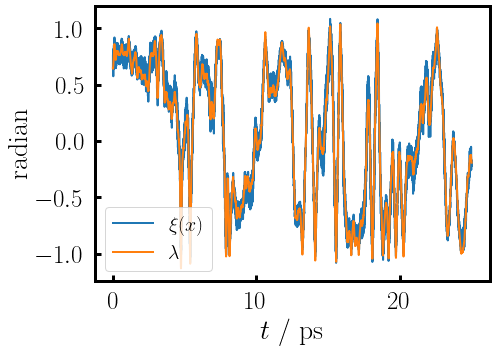

In [27]:
fig, ax = plt.subplots(1, figsize=(7, 5), sharex=True)

ax.plot(exttraj[:, 0], exttraj[:, 4],
        linewidth=2,
        label=r"$\xi(x)$")
ax.plot(exttraj[:, 0], exttraj[:, 5],
        linewidth=2,
        label=r"$\lambda$")


ax.set_xlabel(r'$t$ / ps', fontsize=28)
ax.set_ylabel(r'radian', fontsize=28)

ax.tick_params(axis='y', length=6, width=3,
               labelsize=25, pad=10, direction='in')
ax.tick_params(axis='x', length=6, width=3,
               labelsize=25, pad=10, direction='in')
ax.spines['bottom'].set_linewidth('3')
ax.spines['top'].set_linewidth('3')
ax.spines['left'].set_linewidth('3')
ax.spines['right'].set_linewidth('3')

plt.legend(loc='best', frameon=True, fontsize=20)
plt.tight_layout()

plt.show()

In [28]:
# coupling width of the eABF simulation,
# do not change this! this is the value from the simulation
sigma = 0.05

# parameters for the grid for which the trajectory
# is split into fictional umbrella windows
dxi = sigma
min_xi = -1.0
max_xi = 1.0
grid = np.arange(min_xi, max_xi, dxi)

# this function needs the CV-values and the coupled extended variable
traj_cv = exttraj[:, 4]
traj_lam = exttraj[:, 5]

traj_list, indices, meta_f = mbar.get_windows(
    grid, traj_cv, traj_lam, sigma, equil_temp=300.0)

In [29]:
W = mbar.run_mbar(traj_list, meta_f, equil_temp=300.0,
                  outfreq=50, conv=1.0e-6, max_iter=int(1e6))

Making Boltzmann factors

All ready!

Start of the self-consistent iteration.
Iter    1:	Conv=  1.6929657477	Conv_errvec=    288.348620
Iter   50:	Conv=  0.0744640562	Conv_errvec=     32.782550
Iter  100:	Conv=  0.0176386772	Conv_errvec=      8.453941
Iter  150:	Conv=  0.0036682342	Conv_errvec=      2.275731
Iter  200:	Conv=  0.0012942916	Conv_errvec=      1.083519
Iter  250:	Conv=  0.0011008285	Conv_errvec=      0.676119
Iter  300:	Conv=  0.0008743885	Conv_errvec=      0.483786
Iter  350:	Conv=  0.0006810846	Conv_errvec=      0.364454
Iter  400:	Conv=  0.0005273927	Conv_errvec=      0.279274
Iter  450:	Conv=  0.0004076432	Conv_errvec=      0.215158
Iter  500:	Conv=  0.0003149081	Conv_errvec=      0.166042
Iter  550:	Conv=  0.0002432275	Conv_errvec=      0.128205
Iter  600:	Conv=  0.0001878532	Conv_errvec=      0.099006
Iter  650:	Conv=  0.0001450834	Conv_errvec=      0.076462
Iter  700:	Conv=  0.0001120507	Conv_errvec=      0.059052
Iter  750:	Conv=  0.0000865388	Conv_errvec=      0.0

In [30]:
pmf, rho = mbar.pmf_from_weights(grid, traj_cv[indices], W, equil_temp=300.0)

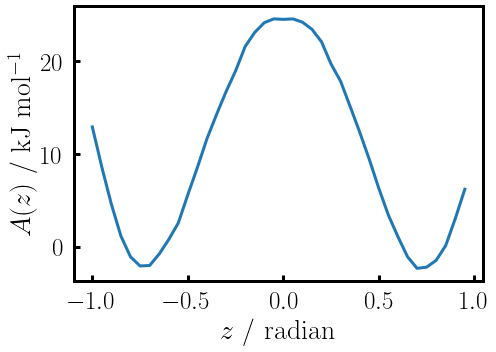

In [31]:
fig, ax = plt.subplots(1, figsize=(7, 5), sharex=True)

ax.plot(grid, pmf,
        linewidth=3)

ax.set_xlabel(r'$z$ / radian', fontsize=28)
ax.set_ylabel(r'$A(z)$ / kJ mol$^{-1}$', fontsize=28)

ax.tick_params(axis='y', length=6, width=3,
               labelsize=25, pad=10, direction='in')
ax.tick_params(axis='x', length=6, width=3,
               labelsize=25, pad=10, direction='in')
ax.spines['bottom'].set_linewidth('3')
ax.spines['top'].set_linewidth('3')
ax.spines['left'].set_linewidth('3')
ax.spines['right'].set_linewidth('3')

plt.tight_layout()

plt.show()

### WTMeABF

In [32]:
# Let's start exactly where the other simulation started
atoms = AtomsBatch.from_atoms(start_geom,
                              )

# use the distance of the scan for center of umbrella window
CV = ColVar(info_dict)
cv, cv_grad = CV(atoms)

In [34]:
# Most things look very similar to eABF
# The differences are:
# - hill_std in the cv dictionary, because
#    one might want to specify different Gaussian
#    hill width for different cvs
# - The calculator has now the additional hill depostion related options

cv_defs = [{'definition': info_dict,
            'range': [-1.0, 1.0],
            'ext_sigma': 0.05,  # approx k = 10 eV/A^2 = 1000 kJ/mol A^2
            'ext_mass': 20.0,
            'ext_pos': cv,
            'margin': 0.1,
            'conf_k': 0.1,
            'hill_std': 0.025,
            'type': 'angle',
            },
           ]

model = load_model('models/ammonia/',
                   device=device)

calculator = WTMeABF(model,
                     cv_defs=cv_defs,
                     dt=0.5,
                     friction_per_ps=1.0,
                     equil_temp=300.0,
                     nfull=100,
                     hill_height=0.01,
                     hill_drop_freq=100,
                     directed=True,
                     device=device,
                     )

atoms.set_calculator(calculator)

dyn = Langevin(atoms,
               timestep=0.5,
               temperature=300.0,
               friction_per_ps=1.0,
               maxwell_temp=300.0,
               logfile='WTMeABF_MD.log',
               trajectory='WTMeABF.traj',
               )

dyn.attach(BiasedNeuralMDLogger(dyn,
                                atoms,
                                'WTMeABF_ext.log',
                                header=True,
                                mode="w"),
           interval=2)

THE RANDOM NUMBER SEED WAS: 14918710


In [35]:
# trajectory of 10 ps (umbrella sampling was 41 ps, eABF 25 ps)
# This is to show the power, one can always sample the same amount
dyn.run(steps=int(2e4))

100%|██████████| 1000/1000 [02:31<00:00,  6.62it/s]


In [36]:
traj = trajectory("WTMeABF.traj", mode="r")
exttraj = np.genfromtxt("WTMeABF_ext.log", skip_header=1)

In [37]:
nv.show_asetraj(traj)

NGLWidget(max_frame=20000)

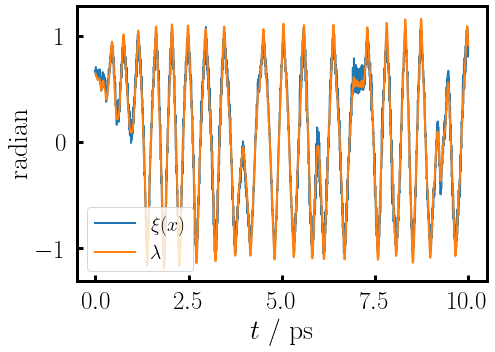

In [38]:
fig, ax = plt.subplots(1, figsize=(7, 5), sharex=True)

ax.plot(exttraj[:, 0], exttraj[:, 4],
        linewidth=2,
        label=r"$\xi(x)$")
ax.plot(exttraj[:, 0], exttraj[:, 5],
        linewidth=2,
        label=r"$\lambda$")


ax.set_xlabel(r'$t$ / ps', fontsize=28)
ax.set_ylabel(r'radian', fontsize=28)

# ax.set_xlim([0, 50])

ax.tick_params(axis='y', length=6, width=3,
               labelsize=25, pad=10, direction='in')
ax.tick_params(axis='x', length=6, width=3,
               labelsize=25, pad=10, direction='in')
ax.spines['bottom'].set_linewidth('3')
ax.spines['top'].set_linewidth('3')
ax.spines['left'].set_linewidth('3')
ax.spines['right'].set_linewidth('3')

plt.legend(loc='best', frameon=True, fontsize=20)
plt.tight_layout()

plt.show()

In [39]:
# all parameters are pretty much as before
# this function needs the CV-values and the coupled extended variable
traj_cv = exttraj[:, 4]
traj_lam = exttraj[:, 5]

traj_list, indices, meta_f = mbar.get_windows(
    grid, traj_cv, traj_lam, sigma, equil_temp=300.0)

In [40]:
W = mbar.run_mbar(traj_list, meta_f, equil_temp=300.0,
                  outfreq=50, conv=1.0e-6, max_iter=int(1e6))

Making Boltzmann factors

All ready!

Start of the self-consistent iteration.
Iter    1:	Conv=  1.6853635065	Conv_errvec=     89.534683
Iter   50:	Conv=  0.0737407568	Conv_errvec=     11.114510
Iter  100:	Conv=  0.0177382531	Conv_errvec=      2.638867
Iter  150:	Conv=  0.0037728531	Conv_errvec=      0.664207
Iter  200:	Conv=  0.0010323462	Conv_errvec=      0.292851
Iter  250:	Conv=  0.0008513043	Conv_errvec=      0.174225
Iter  300:	Conv=  0.0006470029	Conv_errvec=      0.117952
Iter  350:	Conv=  0.0004798850	Conv_errvec=      0.084114
Iter  400:	Conv=  0.0003531712	Conv_errvec=      0.061097
Iter  450:	Conv=  0.0002592569	Conv_errvec=      0.044656
Iter  500:	Conv=  0.0001901573	Conv_errvec=      0.032707
Iter  550:	Conv=  0.0001394365	Conv_errvec=      0.023971
Iter  600:	Conv=  0.0001022353	Conv_errvec=      0.017573
Iter  650:	Conv=  0.0000749571	Conv_errvec=      0.012883
Iter  700:	Conv=  0.0000549566	Conv_errvec=      0.009446
Iter  750:	Conv=  0.0000402927	Conv_errvec=      0.0

In [41]:
pmf, rho = mbar.pmf_from_weights(grid, traj_cv[indices], W, equil_temp=300.0)

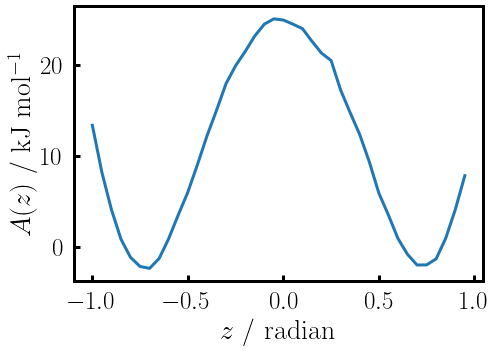

In [42]:
fig, ax = plt.subplots(1, figsize=(7, 5), sharex=True)

ax.plot(grid, pmf,
        linewidth=3)

ax.set_xlabel(r'$z$ / radian', fontsize=28)
ax.set_ylabel(r'$A(z)$ / kJ mol$^{-1}$', fontsize=28)

ax.tick_params(axis='y', length=6, width=3,
               labelsize=25, pad=10, direction='in')
ax.tick_params(axis='x', length=6, width=3,
               labelsize=25, pad=10, direction='in')
ax.spines['bottom'].set_linewidth('3')
ax.spines['top'].set_linewidth('3')
ax.spines['left'].set_linewidth('3')
ax.spines['right'].set_linewidth('3')

plt.tight_layout()

plt.show()